## VIF 미제거

### 코랩 다운로드

In [2]:
!pip install "numpy<2.0" --force-reinstall
! pip install rtdl
! pip install git+https://github.com/yura52/rtdl.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: tor

In [ ]:
import os; os.kill(os.getpid(), 9)  #  런타임 재시작

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.5 MB/s eta 0:00:00


### 라이브러리 호출

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pickle
import matplotlib.pyplot as plt


# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


### 인코딩

In [ ]:
df=pd.read_csv('../real_data/공시지가_전처리.csv')

| 구분   | 모델명                               | 설명                                                  |
| ---- | --------------------------------- | --------------------------------------------------- |
|  1 | **CatBoost Regressor**            | 범주형 데이터와 원-핫 인코딩 없이도 강력한 성능 (but 이미 원-핫이면 그냥 사용 가능) |
|  2 | **LightGBM Regressor**            | 속도 빠르고 대규모 데이터에 강함, 부스팅 기반                          |
|  3 | **XGBoost Regressor**             | 안정적이고 널리 사용되는 부스팅 모델                                |
|  4 | **HistGradientBoostingRegressor** | sklearn 최신 트리 기반 모델. 빠르고 튜닝이 쉬움                     |



In [ ]:
# 1. X, y 분리
X = df.drop(columns='내년_공시지가')
y = df['내년_공시지가']

# 1차 분할: train_temp / test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2차 분할: train / valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)



In [ ]:
# 1. 연속형 변수 '면적' 정규화 + 변환
scaler_area = MinMaxScaler()
area_train_scaled = scaler_area.fit_transform(X_train[['면적']])
area_valid_scaled=scaler_area.transform(X_valid[['면적']])
area_test_scaled = scaler_area.transform(X_test[['면적']])

# 2. 범주형 변수 목록 추출 (면적 제외)
categorical_cols = X_train.drop(columns=['면적']).columns.tolist()

# 3. OneHotEncoder 학습 + 변환
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_cat_encoded = encoder.fit_transform(X_train[categorical_cols])
X_valid_cat_encoded = encoder.transform(X_valid[categorical_cols])
X_test_cat_encoded = encoder.transform(X_test[categorical_cols])

# 4. 인코딩된 특성 이름
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# 5. 최종 X_train,X_valid, X_test 구성 -> 면적과 원-핫 처리된 변수들 결합
X_train = pd.DataFrame(
    np.concatenate([area_train_scaled, X_train_cat_encoded], axis=1),
    columns=['면적'] + encoded_feature_names.tolist()
)

X_valid = pd.DataFrame(
    np.concatenate([area_valid_scaled, X_valid_cat_encoded], axis=1),
    columns=['면적'] + encoded_feature_names.tolist()
)

X_test = pd.DataFrame(
    np.concatenate([area_test_scaled, X_test_cat_encoded], axis=1),
    columns=['면적'] + encoded_feature_names.tolist()
)

# 6. 공시지가 정규화
scaler_target = MinMaxScaler()
y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_valid = scaler_target.transform(y_valid.values.reshape(-1, 1))
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

In [ ]:
# 변수명에 존재하는 , 띄어쓰기 '_'로 대체

X_train.columns = X_train.columns.str.replace(',', '_')
X_train.columns = X_train.columns.str.replace(' ', '_')
X_valid.columns = X_valid.columns.str.replace(',', '_')
X_valid.columns = X_valid.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(',', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [ ]:
"""
# 분할 저장
with open("./split_data/split_data_3way.pkl", "wb") as f:
    pickle.dump((X_train, X_valid, X_test, y_train, y_valid, y_test), f)
"""


### ft-transformer 인코딩

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset

# 1. X, y 분리
X = df.drop(columns='내년_공시지가')
y = df['내년_공시지가']

# 2. 3-way split ->random_state 지정으로 동일한 분류
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# 3. 면적 MinMax 스케일링
scaler_area = MinMaxScaler()
X_train['면적'] = scaler_area.fit_transform(X_train[['면적']])
X_valid['면적'] = scaler_area.transform(X_valid[['면적']])
X_test['면적'] = scaler_area.transform(X_test[['면적']])

# 4. 타깃 MinMax 스케일링
scaler_target = MinMaxScaler()
y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_valid = scaler_target.transform(y_valid.values.reshape(-1, 1))
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

# 5. 명목형 변수 라벨 인코딩 ->ft-transformer 모델은 원-핫이 아닌,
# 라벨 인코딩이 더 적합.
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_valid[col] = le.transform(X_valid[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# 변수명에 존재하는 , 띄어쓰기 제거

X_train.columns = X_train.columns.str.replace(',', '_')
X_train.columns = X_train.columns.str.replace(' ', '_')
X_valid.columns = X_valid.columns.str.replace(',', '_')
X_valid.columns = X_valid.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(',', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

# 6. 넘파이로 변환
X_train_np = X_train.values.astype(np.float32)
X_valid_np = X_valid.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

y_train_np = y_train.astype(np.float32)
y_valid_np = y_valid.astype(np.float32)
y_test_np = y_test.astype(np.float32)

# 7. 텐서로 변환 ft-transformer은 텐서형태로 사용됨.
X_train_tensor = torch.tensor(X_train_np)
X_valid_tensor = torch.tensor(X_valid_np)
X_test_tensor = torch.tensor(X_test_np)

y_train_tensor = torch.tensor(y_train_np)
y_valid_tensor = torch.tensor(y_valid_np)
y_test_tensor = torch.tensor(y_test_np)

# 8. Dataset으로 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [ ]:
"""
with open("./split_data/split_data_ft_transformer.pkl", "wb") as f:
    pickle.dump((X_train_tensor, X_valid_tensor, X_test_tensor,
                 y_train_tensor, y_valid_tensor, y_test_tensor), f)
"""

### 머신러닝 학습

In [ ]:
# 실험 재현
with open("./split_data/split_data_3way.pkl", "rb") as f:
    X_train, X_valid, X_test, y_train, y_valid, y_test = pickle.load(f)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR # 사용X
from sklearn.linear_model import Ridge # 사용X
import warnings
import numpy as np
warnings.filterwarnings("ignore")

models = {
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_state=42),
        {
            "depth": [4, 6, 8, 10],
            "learning_rate": [0.01, 0.05, 0.1],
            "iterations": [200, 400, 600], # 반복 횟수
            "l2_leaf_reg": [3, 5, 7] # 정규화 계수
        }
    ),
    "LightGBM": (
        LGBMRegressor( random_state=42),
        {
            "num_leaves": [15, 31, 63],
            "max_depth": [-1, 5, 10, 20],
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [100, 300, 500], # 트리개수
            "min_child_samples": [5, 10, 20] # 잎 당 최소 샘플 개수
        }
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0),
        {
            "max_depth": [3, 5, 7, 10],
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [100, 300],
            "subsample": [0.6, 0.8, 1.0] # 사용할 샘플 비율
        }
    ),
    "HistGBR": (
        HistGradientBoostingRegressor(random_state=42),
        {
            "max_iter": [100, 300, 500],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [20, 50, 100],
            "l2_regularization": [0.0, 0.1, 1.0]
        }
    ),
    "ElasticNet": (
    ElasticNet(random_state=42, max_iter=10000),
    {
        "alpha": [0.01, 0.1, 1.0, 10.0], # 전체 규제 강도
        "l1_ratio": [0.1, 0.5, 0.9],  # l1, l2비율
        "tol": [1e-4, 1e-3, 1e-2]  # 수렴 허용 오차
    }
)
}

results = {}
total_models = len(models)

for i, (name, (model, param_grid)) in enumerate(models.items()):
    print(f"\n🔍 [{i+1}/{total_models}] Random Search for {name}...")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10, # 조합 수
        scoring="neg_mean_squared_error", # 최소 mse값
        cv=3,    # 교차 검증 횟수
        n_jobs=-1, # cpu 병렬처리
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train.ravel())

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "best_params": search.best_params_,
        "test_rmse": rmse,
        "test_r2": r2
    }

    # 개별 결과 즉시 출력
    print(f"✅ {name} 학습 완료")
    print(f"📌 최적 파라미터: {search.best_params_}")
    print(f"📊 테스트 RMSE: {rmse:.6f}")
    print(f"📈 테스트 R²: {r2:.4f}")

# 전체 결과 요약
print("\n✅ 최종 결과 요약:")
for model_name, res in results.items():
    print(f"📌 {model_name} | RMSE: {res['test_rmse']:.6f} | R²: {res['test_r2']:.4f} | Best Params: {res['best_params']}")




🔍 [1/5] Random Search for CatBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ CatBoost 학습 완료
📌 최적 파라미터: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 8}
📊 테스트 RMSE: 0.009246
📈 테스트 R²: 0.6731

🔍 [2/5] Random Search for LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 298092, number of used features: 89
[LightGBM] [Info] Start training from score 0.005130
✅ LightGBM 학습 완료
📌 최적 파라미터: {'num_leaves': 15, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.05}
📊 테스트 RMSE: 0.009272
📈 테스트 R²: 0.6713

🔍 [3/5] Random Search for XGBoost...
Fitting 3 folds for each of 10 candidates, tot

ElasticNET 성능이 너무 안좋아, RandomForest Regressor 추가

In [ ]:
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ⏱ 시간 측정 시작
start = time.time()

# 1. 모델 및 파라미터 후보 정의
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2]
}

# 2. 랜덤 서치
search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("🔍 Random Forest 하이퍼파라미터 탐색 중...")
search.fit(X_train, y_train.ravel())

# 3. 예측 및 평가
best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 4. 결과 출력
print(f"✅ RandomForest 학습 완료")
print(f"📌 최적 파라미터: {search.best_params_}")
print(f"📊 테스트 RMSE: {rmse:.6f}")
print(f"📈 테스트 R²: {r2:.4f}")

# ⏱ 시간 측정 종료
print(f"⏱ 실행 시간: {(time.time() - start):.2f}초")



🔍 Random Forest 하이퍼파라미터 탐색 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ RandomForest 학습 완료
📌 최적 파라미터: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 10}
📊 테스트 RMSE: 0.009356
📈 테스트 R²: 0.6653
⏱ 실행 시간: 14703.43초


catboost 확장 탐색

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import numpy as np

# CatBoost 확장된 탐색 범위
catboost_params = {
    "depth": [4, 6, 8, 10, 12],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "iterations": [300, 500, 700, 1000], # 트리 개수
    "l2_leaf_reg": [1, 3, 5, 7, 9], # l2정규화 강도
    "bagging_temperature": [0.0, 0.5, 1.0, 1.5], # 랜덤성 조절 파라미터
    "border_count": [32, 64, 128] # 연속형 변수를 이산형으로 나눌 때 경계 개수
}

catboost = CatBoostRegressor(task_type='GPU', verbose=5, random_state=42)

search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=catboost_params,
    n_iter=30,  # 깊게 탐색
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train.ravel())

# 평가
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n✅ CatBoost 정밀 탐색 완료")
print(f"📌 최적 파라미터: {search.best_params_}")
print(f"📊 테스트 RMSE: {rmse:.6f}")
print(f"📈 테스트 R²: {r2:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 0.0149432	total: 7.22ms	remaining: 7.21s
5:	learn: 0.0116791	total: 39.5ms	remaining: 6.54s
10:	learn: 0.0101915	total: 70.6ms	remaining: 6.34s
15:	learn: 0.0095158	total: 103ms	remaining: 6.33s
20:	learn: 0.0092019	total: 134ms	remaining: 6.24s
25:	learn: 0.0090190	total: 165ms	remaining: 6.17s
30:	learn: 0.0089109	total: 193ms	remaining: 6.02s
35:	learn: 0.0088397	total: 219ms	remaining: 5.86s
40:	learn: 0.0087867	total: 242ms	remaining: 5.67s
45:	learn: 0.0087358	total: 271ms	remaining: 5.61s
50:	learn: 0.0086876	total: 295ms	remaining: 5.48s
55:	learn: 0.0086548	total: 318ms	remaining: 5.37s
60:	learn: 0.0086318	total: 342ms	remaining: 5.26s
65:	learn: 0.0085985	total: 365ms	remaining: 5.17s
70:	learn: 0.0085688	total: 388ms	remaining: 5.08s
75:	learn: 0.0085453	total: 407ms	remaining: 4.95s
80:	learn: 0.0085131	total: 429ms	remaining: 4.86s
85:	learn: 0.0084926	total: 448ms	remaining: 4.76s
90:	learn: 0.0084643

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Min-Max 정규화 기준값
y_min = 216.0
y_max = 165300000.0

# 2. 최적 하이퍼파라미터 적용 모델 정의
models = {
    "CatBoost": CatBoostRegressor(
        learning_rate=0.1,
        l2_leaf_reg=3,
        iterations=1000,
        depth=6,
        border_count=128,
        verbose=0,
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        num_leaves=15,
        n_estimators=500,
        min_child_samples=20,
        max_depth=-1,
        learning_rate=0.05,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        subsample=1.0,
        n_estimators=100,
        max_depth=7,
        learning_rate=0.2,
        random_state=42,
        verbosity=0
    ),
    "HistGBR": HistGradientBoostingRegressor(
        min_samples_leaf=50,
        max_iter=500,
        max_depth=10,
        learning_rate=0.1,
        l2_regularization=0.1,
        random_state=42
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        min_samples_split=6,
        min_samples_leaf=2,
        max_depth=10,
        random_state=42
    )
}

# 3. 결과 저장용 딕셔너리
results = {}

# 4. 모델 학습 → 예측 → 역정규화 → 성능 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 역정규화
    preds_inverse = preds * (y_max - y_min) + y_min
    y_test_inverse = y_test * (y_max - y_min) + y_min

    # 성능 평가
    mse = mean_squared_error(y_test_inverse, preds_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inverse, preds_inverse)

    results[name] = {
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4)
    }

# 5. 결과 출력
print("📊 역정규화 기준 모델 성능 비교:")
for name, res in results.items():
    print(f"✅ {name:<10} | RMSE: {res['RMSE']:,} | R²: {res['R²']}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 298092, number of used features: 89
[LightGBM] [Info] Start training from score 0.005130
📊 역정규화 기준 모델 성능 비교:
✅ CatBoost   | RMSE: 1,518,386.06 | R²: 0.6774
✅ LightGBM   | RMSE: 1,532,644.61 | R²: 0.6713
✅ XGBoost    | RMSE: 1,526,182.97 | R²: 0.6741
✅ HistGBR    | RMSE: 1,538,908.34 | R²: 0.6686
✅ RandomForest | RMSE: 1,546,480.83 | R²: 0.6653


### tabnet

In [ ]:
import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

def objective(trial):
    model = TabNetRegressor(
        n_d=trial.suggest_categorical("n_d", [8, 16, 24]), # 디코더 차원 수
        n_a=trial.suggest_categorical("n_a", [8, 16, 24]), #  어텐션 피처 차원 수
        n_steps=trial.suggest_categorical("n_steps", [3, 5]), # 결정 반복 횟수-> 하나의 입력을 여러번 학습
        gamma=trial.suggest_float("gamma", 1.2, 1.5, step=0.1),  # 이전 정보를 얼마나 활용할지 결정
        lambda_sparse=1e-3,  # 희소성 정규화 강도 고정 L1과 유사한 역할
        optimizer_params=dict(lr=0.02),
        verbose=0,
        seed=42
    )

    model.fit(
        X_train=X_train.values,
        y_train=y_train,
        eval_set=[(X_valid.values, y_valid)], #평가용 set
        eval_metric=['rmse'],
        max_epochs=100,
        patience=10, # 조기종료 조건 10번동안 성능 안오를 시 종료
        batch_size=1024,
        virtual_batch_size=128
    )

    preds = model.predict(X_valid.values).squeeze()
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)  # 가볍게 5회만 탐색

print("✅ Best RMSE:", study.best_value)
print("✅ Best Params:", study.best_params)


[I 2025-05-23 16:55:41,741] A new study created in memory with name: no-name-9acb0fcb-e231-481d-9ee4-bb92e68ac524



Early stopping occurred at epoch 57 with best_epoch = 47 and best_val_0_rmse = 0.01043


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-23 17:17:41,598] Trial 0 finished with value: 0.010426763997343673 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.4}. Best is trial 0 with value: 0.010426763997343673.



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_rmse = 0.00838


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-23 17:29:04,354] Trial 1 finished with value: 0.00837982306548217 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.4}. Best is trial 1 with value: 0.00837982306548217.



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_rmse = 0.00886


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-23 17:43:31,484] Trial 2 finished with value: 0.00885509172971668 and parameters: {'n_d': 24, 'n_a': 16, 'n_steps': 5, 'gamma': 1.4}. Best is trial 1 with value: 0.00837982306548217.



Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_0_rmse = 0.00969


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-23 17:50:16,657] Trial 3 finished with value: 0.009691519648185942 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.4}. Best is trial 1 with value: 0.00837982306548217.



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_rmse = 0.01005


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-23 18:03:07,850] Trial 4 finished with value: 0.010054878763500759 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 5, 'gamma': 1.4}. Best is trial 1 with value: 0.00837982306548217.


✅ Best RMSE: 0.00837982306548217
✅ Best Params: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.4}


학습 시간 상 중단, 위에서 나온 제일 좋은 결과로, 하이퍼 파라미터 탐색

In [ ]:
# 하이퍼 파라미터 탐색

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import torch
from tqdm import tqdm
import numpy as np

# tqdm 진행률 바
NUM_TRIALS = 5
pbar = tqdm(total=NUM_TRIALS, desc="🔍 TabNet Tuning Progress")

def objective_hyper(trial):
    model = TabNetRegressor(
        n_d=16,  # 고정
        n_a=8,   # 고정
        n_steps=3,  # 고정
        gamma=1.4,  # 고정
        lambda_sparse=trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        optimizer_params=dict(
            lr=trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        ),
        verbose=0,
        seed=42,
        device_name="cuda" if torch.cuda.is_available() else "cpu"
    )

    model.fit(
        X_train=X_train.values,
        y_train=y_train,
        eval_set=[(X_valid.values, y_valid)],
        eval_metric=['rmse'],
        max_epochs=100,
        patience=10,
        batch_size=trial.suggest_categorical("batch_size", [1024, 2048]),
        virtual_batch_size=trial.suggest_categorical("virtual_batch_size", [64, 128,256])
        compute_importance=False
    )

    preds = model.predict(X_valid.values).squeeze()  # << 먼저 예측
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, preds)

    trial.set_user_attr("r2", r2)
    pbar.update(1)
    return rmse

# Optuna 튜닝 실행
study_hyper = optuna.create_study(direction="minimize")
study_hyper.optimize(objective_hyper, n_trials=NUM_TRIALS)

# 결과 출력
print("📌 Best RMSE:", study_hyper.best_value)
print("📌 Best Hyperparams:", study_hyper.best_params)

best_trial = study_hyper.best_trial
print("📈 Best R²:", best_trial.user_attrs.get("r2", "N/A"))




🔍 TabNet Tuning Progress:   0%|          | 0/5 [00:00<?, ?it/s][I 2025-05-24 08:33:43,513] A new study created in memory with name: no-name-db6a9744-60ac-4d03-9cc1-d81cab9868f2


Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_val_0_rmse = 0.00776


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
🔍 TabNet Tuning Progress:  20%|██        | 1/5 [46:14<3:04:59, 2774.86s/it][I 2025-05-24 09:19:58,373] Trial 0 finished with value: 0.007758764285731629 and parameters: {'lambda_sparse': 5.314882200191176e-05, 'lr': 0.0018811231971805286, 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.007758764285731629.



Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_rmse = 0.01219


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
🔍 TabNet Tuning Progress:  40%|████      | 2/5 [1:01:24<1:23:53, 1677.88s/it][I 2025-05-24 09:35:08,368] Trial 1 finished with value: 0.012190128409198812 and parameters: {'lambda_sparse': 0.008379929965598122, 'lr': 0.025442871494994544, 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.007758764285731629.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_rmse = 0.00841


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
🔍 TabNet Tuning Progress:  60%|██████    | 3/5 [1:18:55<46:22, 1391.34s/it]  [I 2025-05-24 09:52:38,734] Trial 2 finished with value: 0.008407873176965461 and parameters: {'lambda_sparse': 0.0001409525021766939, 'lr': 0.08670183254700944, 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.007758764285731629.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_rmse = 0.00826


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
🔍 TabNet Tuning Progress:  80%|████████  | 4/5 [1:41:45<23:02, 1382.93s/it][I 2025-05-24 10:15:28,766] Trial 3 finished with value: 0.008255294904367792 and parameters: {'lambda_sparse': 2.8736561718466345e-05, 'lr': 0.09718973964557401, 'batch_size': 2048, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.007758764285731629.


Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 0.01224


c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[W 2025-05-24 11:10:47,360] Trial 4 failed with parameters: {'lambda_sparse': 5.4685178076795676e-05, 'lr': 0.00027093081582010576, 'batch_size': 2048, 'virtual_batch_size': 64} because of the following error: MemoryError((278528, 89), dtype('float64')).
Traceback (most recent call last):
  File "c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\jeongbin\AppData\Local\Temp\ipykernel_4760\550073449.py", line 27, in objective_hyper
    model.fit(
  File "c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\abstract_model.py", line 278, in fit
    self.feature_importances_ = self._compute_feature_importances(X_train)
  File "c:\Users\jeongbin\Projects\

MemoryError: Unable to allocate 189. MiB for an array with shape (278528, 89) and data type float64

In [ ]:
# 결과 출력
print("📌 Best RMSE:", study_hyper.best_value)
print("📌 Best Hyperparams:", study_hyper.best_params)

best_trial = study_hyper.best_trial
print("📈 Best R²:", best_trial.user_attrs.get("r2", "N/A"))


📌 Best RMSE: 0.007758764285731629
📌 Best Hyperparams: {'lambda_sparse': 5.314882200191176e-05, 'lr': 0.0018811231971805286, 'batch_size': 1024, 'virtual_batch_size': 256}
📈 Best R²: 0.7412711709293286


### 메모리 부족으로 인해 5회가 아닌 4회동안 기록된 최적값을 이용해 학습 진행

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import numpy as np
import os
# 저장 경로 지정
model_save_path = "./best_tabnet_model.zip"
# 1. 최적 하이퍼파라미터
best_params = {
    'lambda_sparse': 5.314882200191176e-05,
    'lr': 0.0018811231971805286,
    'batch_size': 1024,
    'virtual_batch_size': 256
}

# 2. TabNet 모델 생성
model = TabNetRegressor(
    n_d=16,
    n_a=8,
    n_steps=3,
    gamma=1.4,
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_params=dict(lr=best_params['lr']),
    verbose=1,
    seed=42,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

# 3. 학습
model.fit(
    X_train=X_train.values.astype(np.float32),  # float32로 변환해서 메모리 절약
    y_train=y_train,
    eval_set=[(X_valid.values.astype(np.float32), y_valid)],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=best_params['batch_size'],
    virtual_batch_size=best_params['virtual_batch_size']
)

# 4. 예측
preds = model.predict(X_test.values.astype(np.float32)).squeeze()

# 5. 역정규화
y_min = 216.0
y_max = 165300000.0

preds_inverse = preds * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# 성능 평가
mse = mean_squared_error(y_test_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, preds_inverse)

print(f"✅ 최종 RMSE: {rmse:.5f}")
print(f"✅ 최종 R²: {r2:.5f}")


epoch 0  | loss: 0.36183 | val_0_rmse: 0.04153 |  0:00:27s
epoch 1  | loss: 0.00359 | val_0_rmse: 0.03013 |  0:00:52s
epoch 2  | loss: 0.00152 | val_0_rmse: 0.02295 |  0:01:21s
epoch 3  | loss: 0.00093 | val_0_rmse: 0.01927 |  0:01:50s
epoch 4  | loss: 0.00063 | val_0_rmse: 0.01751 |  0:02:20s
epoch 5  | loss: 0.00049 | val_0_rmse: 0.01618 |  0:02:48s
epoch 6  | loss: 0.0004  | val_0_rmse: 0.01563 |  0:03:18s
epoch 7  | loss: 0.00037 | val_0_rmse: 0.0147  |  0:03:47s
epoch 8  | loss: 0.00033 | val_0_rmse: 0.01432 |  0:04:14s
epoch 9  | loss: 0.00031 | val_0_rmse: 0.014   |  0:04:43s
epoch 10 | loss: 0.00029 | val_0_rmse: 0.01378 |  0:05:10s
epoch 11 | loss: 0.00028 | val_0_rmse: 0.01378 |  0:05:39s
epoch 12 | loss: 0.00027 | val_0_rmse: 0.01364 |  0:06:07s
epoch 13 | loss: 0.00027 | val_0_rmse: 0.0135  |  0:06:35s
epoch 14 | loss: 0.00026 | val_0_rmse: 0.01349 |  0:07:02s
epoch 15 | loss: 0.00026 | val_0_rmse: 0.0135  |  0:07:31s
epoch 16 | loss: 0.00026 | val_0_rmse: 0.01353 |  0:08:0

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


✅ 최종 RMSE: 1568550.27499
✅ 최종 R²: 0.65572


In [ ]:
# 학습 완료된 model 객체 저장
model.save_model("best_tabnet_model")


Successfully saved model at best_tabnet_model.zip


'best_tabnet_model.zip'

In [ ]:
"""
loaded_model = TabNetRegressor()
loaded_model.load_model("./model/best_tabnet_model.zip")

# 예측 가능
preds = loaded_model.predict(X_test.values.astype(np.float32)).squeeze()
r2 = r2_score(y_test, preds)
print(r2)
"""

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


0.6557154562734671


### ft-transformer

In [ ]:
import pandas as pd
import pickle
# ✅ 데이터 로딩
with open("split_data_ft_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)
# 텐서를 DataFrame으로 변환
df = pd.DataFrame(X_train_tensor.numpy())

# 각 열마다 고윳값 개수 출력
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"변수 {col} → 고윳값 개수: {unique_count}")


변수 0 → 고윳값 개수: 3
변수 1 → 고윳값 개수: 15
변수 2 → 고윳값 개수: 7
변수 3 → 고윳값 개수: 30954
변수 4 → 고윳값 개수: 14
변수 5 → 고윳값 개수: 9
변수 6 → 고윳값 개수: 6
변수 7 → 고윳값 개수: 4
변수 8 → 고윳값 개수: 6
변수 9 → 고윳값 개수: 12
변수 10 → 고윳값 개수: 6
변수 11 → 고윳값 개수: 3
변수 12 → 고윳값 개수: 12
변수 13 → 고윳값 개수: 2
변수 14 → 고윳값 개수: 3


In [ ]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
import optuna

# ✅ GPU 설정 (코랩에서 진행)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 데이터 로딩
with open("split_data_ft_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# ✅ 연속형: 3번 인덱스만 / 나머지는 범주형
num_indices = [3]
cat_indices = [i for i in range(X_train_tensor.shape[1]) if i != 3]

# ✅ 범주형 변수 고유값 개수
cat_cardinalities = [
    int(X_train_tensor[:, i].max().item()) + 1
    for i in cat_indices
]

# ✅ 입력 분리 함수
def split_features(X_tensor):
    x_num = X_tensor[:, num_indices].float()
    x_cat = X_tensor[:, cat_indices].long()  #  long() 추가
    return x_num, x_cat

# ✅ DataLoader 구성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)

# ✅ Optuna 목적 함수
def objective(trial):
    # 하이퍼파라미터 샘플링
    d_token = trial.suggest_categorical("d_token", [32, 64, 128])
    n_blocks = trial.suggest_int("n_blocks", 2, 6)
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    ffn_d_hidden = trial.suggest_categorical("ffn_d_hidden", [128, 256, 512])

    # ✅ 모델 정의
    model = FTTransformer.make_baseline(
        n_num_features=len(num_indices),
        cat_cardinalities=cat_cardinalities,
        d_token=d_token,
        n_blocks=n_blocks,
        attention_dropout=dropout,
        ffn_d_hidden=ffn_d_hidden,
        ffn_dropout=dropout,
        residual_dropout=dropout,
        d_out=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    best_rmse = float("inf")
    patience = 10
    trigger_times = 0

    for epoch in range(80):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_num, x_cat = split_features(xb)
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            preds = model(x_num, x_cat)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ✅ 검증
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in valid_loader:
                xb = xb.to(device)
                x_num, x_cat = split_features(xb)
                pred = model(x_num, x_cat)
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.numpy() - preds) ** 2))

        # ✅ 조기 종료
        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

# ✅ Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# ✅ 결과 출력
print("Best trial:")
print(study.best_trial)


[I 2025-06-07 15:50:59,845] A new study created in memory with name: no-name-7a1507ff-9524-4f09-b93a-4808e4cafb01


Using device: cuda


[I 2025-06-07 16:13:11,165] Trial 0 finished with value: 0.007743737660348415 and parameters: {'d_token': 128, 'n_blocks': 4, 'n_heads': 2, 'dropout': 0.33091364406781176, 'ffn_d_hidden': 512}. Best is trial 0 with value: 0.007743737660348415.
[I 2025-06-07 16:23:22,891] Trial 1 finished with value: 0.00785342138260603 and parameters: {'d_token': 32, 'n_blocks': 4, 'n_heads': 4, 'dropout': 0.433636849327123, 'ffn_d_hidden': 128}. Best is trial 0 with value: 0.007743737660348415.
[I 2025-06-07 16:29:13,561] Trial 2 finished with value: 0.008003488183021545 and parameters: {'d_token': 64, 'n_blocks': 3, 'n_heads': 4, 'dropout': 0.4855313235003095, 'ffn_d_hidden': 128}. Best is trial 0 with value: 0.007743737660348415.
[I 2025-06-07 16:37:35,607] Trial 3 finished with value: 0.007921209558844566 and parameters: {'d_token': 32, 'n_blocks': 4, 'n_heads': 2, 'dropout': 0.4374995274986443, 'ffn_d_hidden': 128}. Best is trial 0 with value: 0.007743737660348415.
[I 2025-06-07 17:09:34,092] Tria

Best trial:
FrozenTrial(number=4, state=1, values=[0.007526722736656666], datetime_start=datetime.datetime(2025, 6, 7, 16, 37, 35, 607975), datetime_complete=datetime.datetime(2025, 6, 7, 17, 9, 34, 92038), params={'d_token': 128, 'n_blocks': 5, 'n_heads': 2, 'dropout': 0.1476045541216017, 'ffn_d_hidden': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'d_token': CategoricalDistribution(choices=(32, 64, 128)), 'n_blocks': IntDistribution(high=6, log=False, low=2, step=1), 'n_heads': CategoricalDistribution(choices=(2, 4, 8)), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'ffn_d_hidden': CategoricalDistribution(choices=(128, 256, 512))}, trial_id=4, value=None)


In [1]:
fixed_params = {
    "d_token": 128,
    "n_blocks": 5,
    "n_heads": 2,
    "dropout": 0.1476045541216017,
    "ffn_d_hidden": 128
}


In [9]:
import optuna
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
import optuna
# ✅ GPU 설정 (코랩에서 진행)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 데이터 로딩
with open("split_data_ft_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

num_indices = [3]
cat_indices = [i for i in range(X_train_tensor.shape[1]) if i != 3]

# ✅ 범주형 변수 고유값 개수
cat_cardinalities = [
    int(X_train_tensor[:, i].max().item()) + 1
    for i in cat_indices
]
# ✅ 입력 분리 함수
def split_features(X_tensor):
    x_num = X_tensor[:, num_indices].float()
    x_cat = X_tensor[:, cat_indices].long()  #  long() 추가
    return x_num, x_cat

# ✅ DataLoader 구성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)

def hparam_objective(trial):
    # ✅ 탐색 대상 학습 하이퍼파라미터
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])

    # ✅ 고정 구조 하이퍼파라미터
    model = FTTransformer.make_baseline(
        n_num_features=len(num_indices),
        cat_cardinalities=cat_cardinalities,
        d_token=fixed_params["d_token"],
        n_blocks=fixed_params["n_blocks"],
        attention_dropout=fixed_params["dropout"],
        ffn_d_hidden=fixed_params["ffn_d_hidden"],
        ffn_dropout=fixed_params["dropout"],
        residual_dropout=fixed_params["dropout"],
        d_out=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    # ✅ 배치사이즈 반영
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    best_rmse = float("inf")
    patience = 10
    trigger_times = 0

    for epoch in range(80):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_num, x_cat = split_features(xb)  # ✅ 수정된 부분
            x_num, x_cat = x_num.to(device), x_cat.to(device)

            optimizer.zero_grad()
            preds = model(x_num, x_cat)  # ✅ 수정된 부분
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

        # ✅ 검증
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in valid_loader:
                xb = xb.to(device)
                x_num, x_cat = split_features(xb)  # ✅ 수정된 부분
                x_num, x_cat = x_num.to(device), x_cat.to(device)

                pred = model(x_num, x_cat)  # ✅ 수정된 부분
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.numpy() - preds) ** 2))

        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

# ✅ Optuna 실행
study_hparam = optuna.create_study(direction="minimize")
study_hparam.optimize(hparam_objective, n_trials=5)

print("Best trial:")
print(study_hparam.best_trial)


[I 2025-06-08 03:32:22,033] A new study created in memory with name: no-name-d7c84442-651f-44f2-9b04-f49075f61191


Using device: cuda


[I 2025-06-08 03:39:35,854] Trial 0 finished with value: 0.00887646246701479 and parameters: {'lr': 0.00018880225028845442, 'weight_decay': 0.009014651901957674, 'batch_size': 2048}. Best is trial 0 with value: 0.00887646246701479.
[I 2025-06-08 03:51:07,795] Trial 1 finished with value: 0.008109040558338165 and parameters: {'lr': 0.00020817657634782943, 'weight_decay': 0.0064234854267522035, 'batch_size': 1024}. Best is trial 1 with value: 0.008109040558338165.
[I 2025-06-08 03:59:01,229] Trial 2 finished with value: 0.009245762601494789 and parameters: {'lr': 0.00036692557357585726, 'weight_decay': 0.0006471050252809052, 'batch_size': 2048}. Best is trial 1 with value: 0.008109040558338165.
[I 2025-06-08 04:13:03,823] Trial 3 finished with value: 0.007885748520493507 and parameters: {'lr': 0.001569851841594099, 'weight_decay': 0.004428466921695153, 'batch_size': 1024}. Best is trial 3 with value: 0.007885748520493507.
[I 2025-06-08 04:27:09,502] Trial 4 finished with value: 0.0081088

Best trial:
FrozenTrial(number=3, state=1, values=[0.007885748520493507], datetime_start=datetime.datetime(2025, 6, 8, 3, 59, 1, 230832), datetime_complete=datetime.datetime(2025, 6, 8, 4, 13, 3, 823236), params={'lr': 0.001569851841594099, 'weight_decay': 0.004428466921695153, 'batch_size': 1024}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.003, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.01, log=False, low=0.0, step=None), 'batch_size': CategoricalDistribution(choices=(512, 1024, 2048))}, trial_id=3, value=None)


In [10]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 고정된 모델 및 학습 파라미터
best_model_params = {
    "d_token": 128,
    "n_blocks": 5,
    "n_heads": 2,
    "dropout": 0.1476045541216017,
    "ffn_d_hidden": 128
}

best_hparam = {
    "lr": 0.001569851841594099,
    "weight_decay": 0.004428466921695153,
    "batch_size": 1024
}

# ✅ 데이터 준비: train + valid 합치기
X_final_tensor = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_final_tensor = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

train_dataset = TensorDataset(X_final_tensor, y_final_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=best_hparam["batch_size"], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=best_hparam["batch_size"], shuffle=False, pin_memory=True)

# ✅ 모델 정의
model = FTTransformer.make_baseline(
    n_num_features=len(num_indices),
    cat_cardinalities=cat_cardinalities,
    d_token=best_model_params["d_token"],
    n_blocks=best_model_params["n_blocks"],
    attention_dropout=best_model_params["dropout"],
    ffn_d_hidden=best_model_params["ffn_d_hidden"],
    ffn_dropout=best_model_params["dropout"],
    residual_dropout=best_model_params["dropout"],
    d_out=1
).to(device)

# ✅ 학습 준비
optimizer = torch.optim.AdamW(model.parameters(), lr=best_hparam["lr"], weight_decay=best_hparam["weight_decay"])
loss_fn = nn.MSELoss()
patience = 10
trigger_times = 0
best_rmse = float("inf")

# ✅ 학습 루프
for epoch in range(80):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        x_num, x_cat = split_features(xb)
        x_num, x_cat = x_num.to(device), x_cat.to(device)

        optimizer.zero_grad()
        preds = model(x_num, x_cat)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

# ✅ 테스트 예측
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        x_num, x_cat = split_features(xb)
        x_num, x_cat = x_num.to(device), x_cat.to(device)

        pred = model(x_num, x_cat)
        preds.append(pred.cpu().numpy())

preds = np.vstack(preds)
y_test = y_test_tensor.numpy()

# ✅ 역정규화
y_min = 216.0
y_max = 165300000.0

preds_inverse = preds * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# ✅ 성능 평가
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, preds_inverse)

print(f"✅ 최종 RMSE: {rmse:,.2f}")
print(f"✅ 최종 R²: {r2:.5f}")


✅ 최종 RMSE: 1,533,396.15
✅ 최종 R²: 0.67097


In [11]:
torch.save(model, "fttransformer_trained.pt")


In [ ]:
"""
# 모델 불러오기
model = torch.load("fttransformer_trained.pt")
model.to(device)
model.eval()  # 평가 모드 전환

# 예측
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = model(xb, None)  # 수치형-only 입력
        preds.append(pred.cpu().numpy())

preds = np.vstack(preds)
print(preds)
"""

[[1.3846904e-05]
 [2.4620444e-05]
 [2.9076960e-02]
 ...
 [6.8318099e-05]
 [2.1006912e-05]
 [1.0691740e-02]]


### 전체 결과 시각화

In [1]:
import pandas as pd

# 주어진 모델 성능 결과 기반 데이터프레임 생성
df_results = pd.DataFrame([
    {"모델명": "CatBoost", "RMSE": 1518386.06, "R²": 0.6774},
    {"모델명": "LightGBM", "RMSE": 1532644.61, "R²": 0.6713},
    {"모델명": "XGBoost", "RMSE": 1526182.97, "R²": 0.6741},
    {"모델명": "HistGBR", "RMSE": 1538908.34, "R²": 0.6686},
    {"모델명": "RandomForest", "RMSE": 1546480.83, "R²": 0.6653}
])

# TabNet & FTTransformer 결과 추가
tabnet_result = {"모델명": "TabNet", "RMSE": 1568550.27, "R²": 0.65572}
fttransformer_result = {"모델명": "FTTransformer", "RMSE": 1533396.15, "R²": 0.67097}

df_results = pd.concat([
    df_results,
    pd.DataFrame([tabnet_result, fttransformer_result])
], ignore_index=True)

# 데이터프레임 출력
print(df_results)

             모델명        RMSE       R²
0       CatBoost  1518386.06  0.67740
1       LightGBM  1532644.61  0.67130
2        XGBoost  1526182.97  0.67410
3        HistGBR  1538908.34  0.66860
4   RandomForest  1546480.83  0.66530
5         TabNet  1568550.27  0.65572
6  FTTransformer  1533396.15  0.67097


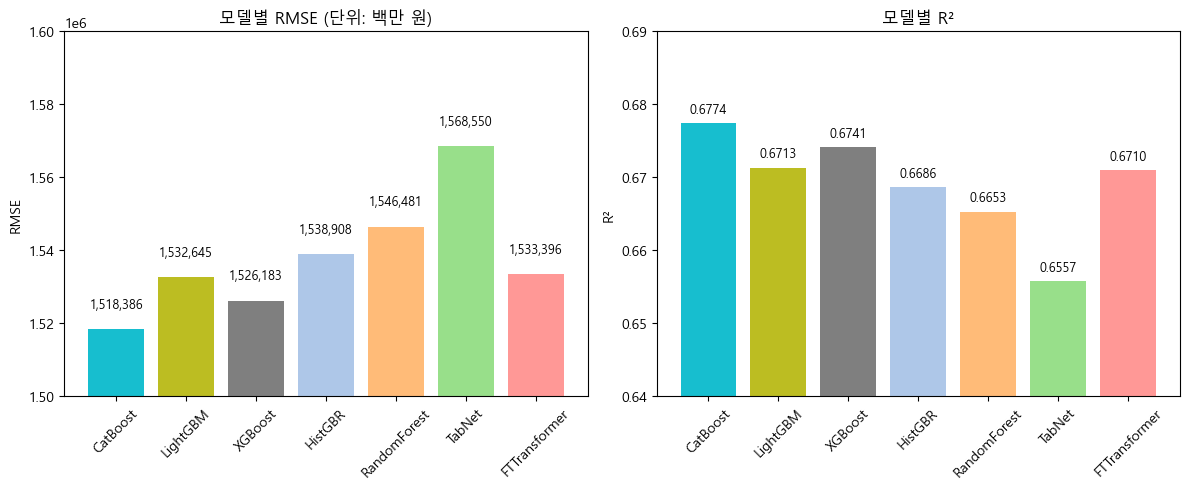

In [5]:
import matplotlib.pyplot as plt 
# 색상 (7개 모델)

colors = ['#17becf', '#bcbd22', '#7f7f7f', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

# 시각화
plt.figure(figsize=(12, 5))

# ✅ RMSE 그래프
plt.subplot(1, 2, 1)
bars_rmse = plt.bar(df_results["모델명"], df_results["RMSE"], color=colors)
plt.title("모델별 RMSE (단위: 백만 원)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.ylim(1500000, 1600000)  # y축 범위 설정

# RMSE 값 표시 (실제 값, 콤마 포함)
for bar in bars_rmse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f"{yval:,.0f}",
             ha='center', va='bottom', fontsize=9)

# ✅ R² 그래프
plt.subplot(1, 2, 2)
bars_r2 = plt.bar(df_results["모델명"], df_results["R²"], color=colors)
plt.title("모델별 R²")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.ylim(0.64, 0.69)  # R² 범위 설정 (차이 강조)

# R² 값 표시
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f"{yval:.4f}",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
